# Sklearn intro 2.0 - other clfs
by Michele Svanera


In [1]:
# All imports
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import time
from sklearn.metrics import classification_report

In [2]:
# Load database
import scipy.io as sio
database = sio.loadmat('./data/mnist-original.mat')

all_data = database['data'].T
GT = database['label'].T

In [3]:
# Add noise
import skimage
all_data = skimage.util.random_noise(all_data, mode='gaussian', var=0.25)

Shape: (70000, 784)
GT values: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


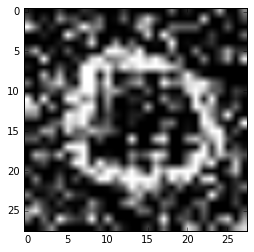

sample range is: MAX=1, min=0


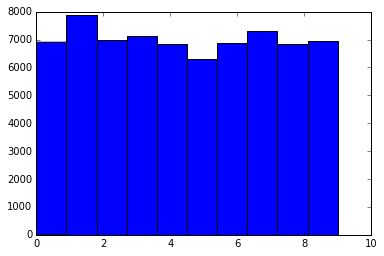

How many samples per class: [ 6903.  7877.  6990.  7141.  6824.  6313.  6876.  7293.  6825.  6958.]


In [4]:
# What we have?
n_samples, m_features = all_data.shape
print 'Shape: ' + str(all_data.shape)
print 'GT values: ' + str(np.unique(GT))

one_sample = np.reshape(all_data[415,:],(int(np.sqrt(m_features)),int(np.sqrt(m_features))))
plt.imshow(one_sample, cmap='gray')
plt.show()
print 'sample range is: MAX=%d, min=%d' % (np.max(one_sample),np.min(one_sample))
plt.figure()
how_many_samples_per_class = plt.hist(GT)
plt.show()
print 'How many samples per class: ' + str(how_many_samples_per_class[0])

In [5]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        all_data, GT, test_size=0.95, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(
        X_test, y_test, test_size=0.50, random_state=42)

y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)

print 'Shape (train): ' + str(X_train.shape)
print 'Shape (valid): ' + str(X_valid.shape)
print 'Shape (test): ' + str(X_test.shape)

Shape (train): (3500, 784)
Shape (valid): (33250, 784)
Shape (test): (33250, 784)


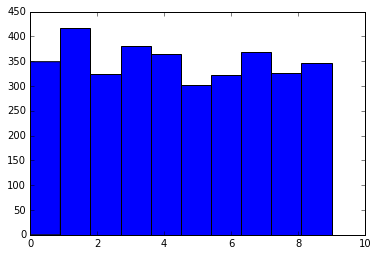

In [57]:
plt.hist(y_train)
plt.show()

In [6]:
# Fast SVM trial
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=42)

t = time.time()
print 'Training linear SVM...'
clf.fit(X_train,y_train)
print 'Done in (sec): %.3f' % (time.time() - t)

y_valid_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_valid_pred, target_names=['Class_' + str(i) for i in np.unique(GT)]))
print 'Total accuracy (%%): %.3f' % (clf.score(X_valid,y_valid)*100)

Training linear SVM...
Done in (sec): 3.152
             precision    recall  f1-score   support

  Class_0.0       0.79      0.84      0.81      3260
  Class_1.0       0.81      0.84      0.82      3793
  Class_2.0       0.72      0.68      0.70      3294
  Class_3.0       0.64      0.68      0.66      3322
  Class_4.0       0.68      0.64      0.66      3278
  Class_5.0       0.54      0.50      0.52      3008
  Class_6.0       0.78      0.78      0.78      3179
  Class_7.0       0.75      0.72      0.73      3520
  Class_8.0       0.55      0.55      0.55      3321
  Class_9.0       0.53      0.55      0.54      3275

avg / total       0.68      0.68      0.68     33250

Total accuracy (%): 68.265


## skopt
Scikit-Optimize ([link](https://scikit-optimize.github.io/)), or skopt, is a simple and efficient library to minimize (very) expensive and noisy black-box functions. It implements several methods for sequential model-based optimization. skopt is reusable in many contexts and accessible.

In [7]:
7# I want to test my opt algo on valid data, not on train data
from sklearn.model_selection import PredefinedSplit

valid_test_fold = np.concatenate((np.zeros((X_train.shape[0],))-1,np.zeros((X_valid.shape[0],))))
ps_for_valid = PredefinedSplit(test_fold=valid_test_fold)
print np.sum(valid_test_fold)
print np.concatenate((X_train,X_valid)).shape

-3500.0
(36750, 784)


In [8]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split

opt = BayesSearchCV(SVC(random_state=42), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 
                            'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 
                            'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, 
                    cv=ps_for_valid, n_iter=15, n_jobs=6)
t = time.time()
opt.fit(np.concatenate((X_train,X_valid)), np.concatenate((y_train,y_valid)))
print 'Optimisation of SVM done in (sec): %.3f' % (time.time() - t)

Optimisation of SVM done in (sec): 2804.647


In [9]:
print opt

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_iter=15, n_jobs=6, optimizer_kwargs={},
       pre_dispatch='2*n_jobs', random_state=None, refit=True,
       return_train_score=True, scoring=None, search_spaces=None,
       verbose=0)


In [10]:
opt.search_spaces_

{0: {'C': Real(low=1e-06, high=1000000.0, prior=log-uniform, transform=identity),
  'degree': Integer(low=1, high=8),
  'gamma': Real(low=1e-06, high=10.0, prior=log-uniform, transform=identity),
  'kernel': Categorical(categories=('linear', 'poly', 'rbf'), prior=None)}}

In [11]:
opt.best_estimator_

SVC(C=134.04882326258769, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=2.181995353604582e-05,
  kernel='poly', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
print 'Score on train-set (%%): %.3f' % (opt.score(X_train, y_train)*100)
print 'Score on valid-set (%%): %.3f' % (opt.score(X_valid, y_valid)*100)
print 'Score on test -set (%%): %.3f' % (opt.score(X_test, y_test)*100)

Score on train-set (%): 88.457
Score on valid-set (%): 89.263
Score on test -set (%): 86.644


### Let's try something else..

In [13]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

y_valid_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_valid_pred, target_names=['Class_' + str(i) for i in np.unique(GT)]))
print 'Total accuracy (%%): %.3f' % (clf.score(X_valid,y_valid)*100)

             precision    recall  f1-score   support

  Class_0.0       0.91      0.87      0.89      3260
  Class_1.0       0.81      0.93      0.87      3793
  Class_2.0       0.85      0.77      0.81      3294
  Class_3.0       0.73      0.75      0.74      3322
  Class_4.0       0.77      0.74      0.75      3278
  Class_5.0       0.69      0.63      0.66      3008
  Class_6.0       0.84      0.87      0.85      3179
  Class_7.0       0.89      0.80      0.84      3520
  Class_8.0       0.69      0.71      0.70      3321
  Class_9.0       0.66      0.73      0.69      3275

avg / total       0.79      0.78      0.78     33250

Total accuracy (%): 78.334


In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_valid_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_valid_pred, target_names=['Class_' + str(i) for i in np.unique(GT)]))
print 'Total accuracy (%%): %.3f' % (clf.score(X_valid,y_valid)*100)

#print(clf.feature_importances_)

             precision    recall  f1-score   support

  Class_0.0       0.50      0.73      0.59      3260
  Class_1.0       0.52      0.81      0.63      3793
  Class_2.0       0.37      0.40      0.39      3294
  Class_3.0       0.35      0.45      0.40      3322
  Class_4.0       0.39      0.42      0.41      3278
  Class_5.0       0.27      0.17      0.21      3008
  Class_6.0       0.50      0.35      0.41      3179
  Class_7.0       0.54      0.46      0.50      3520
  Class_8.0       0.38      0.19      0.26      3321
  Class_9.0       0.35      0.25      0.29      3275

avg / total       0.42      0.43      0.41     33250

Total accuracy (%): 43.140


In [43]:
opt_rf = BayesSearchCV(RandomForestClassifier(random_state=42), {'max_depth': Integer(1, 100),
                        'n_estimators': Integer(1, 50),
                        'max_features': Integer(1, int(X_train.shape[1]*0.75)), }, 
                        cv=ps_for_valid, n_iter=50, n_jobs=6)
t = time.time()
opt_rf.fit(np.concatenate((X_train,X_valid)), np.concatenate((y_train,y_valid)))
print 'Optimisation of RandomForest done in (sec): %.3f' % (time.time() - t)

Optimisation of RandomForest done in (sec): 2157.743


In [44]:
opt_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=92, max_features=276, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=49, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [45]:
print 'Score on train-set (%%): %.3f' % (opt_rf.score(X_train, y_train)*100)
print 'Score on valid-set (%%): %.3f' % (opt_rf.score(X_valid, y_valid)*100)
print 'Score on test -set (%%): %.3f' % (opt_rf.score(X_test, y_test)*100)

Score on train-set (%): 100.000
Score on valid-set (%): 100.000
Score on test -set (%): 74.749


### Let's try something else.. a lot!

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import pandas as pd

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV                             # !!! It needs SKOPT 0.4

In [47]:
# used to try different model classes
pipe = Pipeline([
    ('model', SVC())
])

# single categorical value of 'model' parameter is used  to set the model class
lin_search = {
    'model': Categorical([LinearSVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
}

knn_search = {
    'model': Categorical([KNeighborsClassifier()]),
    'model__n_neighbors': Integer(1, 10),
}

rfc_search = {
    'model': Categorical([RandomForestClassifier()]),
    'model__max_depth': Integer(1, 10),
    'model__n_estimators': Integer(1, 20),
    'model__max_features': Integer(1, 5),
}

mlp_search = {
    'model': Categorical([MLPClassifier()]),
    'model__alpha': Integer(1, 10),
}

nb_search = {
    'model': Categorical([GaussianNB()])
}

ab_search = {
    'model': Categorical([AdaBoostClassifier()])
}

dtc_search = {
    'model': Categorical([DecisionTreeClassifier()]),
    'model__max_depth': Integer(1, 32),
    'model__min_samples_split': Real(1e-3, 1.0, prior='log-uniform'),
}

svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1, 8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
    pipe,
    [(lin_search, 16), (dtc_search, 24), (svc_search, 64),
     (nb_search, 1), (ab_search, 1), (knn_search, 16),
     (rfc_search, 32), (mlp_search, 16)],  # (parameter space, # of evaluations)
    n_jobs=6)

In [48]:
opt.fit(X_train, y_train)

In [49]:
print opt

BayesSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('model', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_iter=50, n_jobs=6, optimizer_kwargs={},
       pre_dispatch='2*n_jobs', random_state=None, refit=True,
       return_train_score=True, scoring=None, search_spaces=None,
       verbose=0)


In [50]:
opt.best_estimator_

Pipeline(memory=None,
     steps=[('model', SVC(C=108331.08965009834, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.016358616627913394,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [51]:
opt.search_spaces_

{0: ({'model': Categorical(categories=(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
        intercept_scaling=1, loss='squared_hinge', max_iter=1000,
        multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
        verbose=0),), prior=None),
   'model__C': Real(low=1e-06, high=1000000.0, prior=log-uniform, transform=identity)},
  16),
 1: ({'model': Categorical(categories=(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
               splitter='best'),), prior=None),
   'model__max_depth': Integer(low=1, high=32),
   'model__min_samples_split': Real(low=0.001, high=1.0, prior=log-uniform, transform=identity)},
  24),
 2: ({'model': Categorical(categories=(SVC(C=1.0, cac

In [52]:
print 'Score on train-set (%%): %.3f' % (opt.score(X_train, y_train)*100)
print 'Score on valid-set (%%): %.3f' % (opt.score(X_valid, y_valid)*100)
print 'Score on test -set (%%): %.3f' % (opt.score(X_test, y_test)*100)

Score on train-set (%): 100.000
Score on valid-set (%): 85.395
Score on test -set (%): 85.374


### The end!

Someone asked for a comparison? Take a look [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)!

Do you want other preprocessing steps? [here](http://scikit-learn.org/stable/modules/preprocessing.html) and [here](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

Do you still want to use SVM?

Really??
Ok, fine: take a look at [this](http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html).

Take a look also [here](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) for good practises with SVM.